In [7]:
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import train_test_split
from sklearn import datasets

from evopipe import steps, evopipe

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
wine = datasets.load_wine()
train_X, test_X, train_Y, test_Y = train_test_split(wine.data, wine.target, test_size = 0.25, random_state = 0)

params = steps.get_params(len(train_X[0]))

In [3]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, params,n_jobs=-1, pre_dispatch='2*n_jobs', verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC
0.5111111111111111
0.4680555555555556


ValueError: Parameter values for parameter (PCA) need to be a sequence(but not a string) or np.ndarray.

In [9]:
scorer = metrics.make_scorer(metrics.cohen_kappa_score, weights='quadratic')
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, ['featsel', 'scaling'], pop_size=300, ngen=30, mutpb=0.5, swap_mutpb=0.2,
                                param_mutpb=0.85, ind_mutpb=0.8, len_mutpb=0.5, scorer=scorer)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))

best_pipes = clf.best_pipelines()

for pipe, score in best_pipes:
    pipe.fit(train_X, train_Y)
    # res_Y = pipe.predict(test_X)
    
    # score = metrics.cohen_kappa_score(test_Y, res_Y, weights='quadratic')
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Score: {}, Pipe: {}".format(score, pipe_named_steps))

evaluating: [('StandardScaler', OrderedDict(), 'scaling'), ('LDA', OrderedDict([('shrinkage', 0.5), ('solver', 'eigen')]))]Evolution starting...
evaluating: [('kBest', OrderedDict([('k', 3), ('score_func', <function chi2 at 0x000001757F2FB400>)]), 'featsel'), ('StandardScaler', OrderedDict(), 'scaling'), ('LDA', OrderedDict([('shrinkage', 0.5), ('solver', 'eigen')]))]
Gen 2:

evaluating: [('StandardScaler', OrderedDict(), 'scaling'), ('logR', OrderedDict([('C', 0.1), ('penalty', 'l2'), ('solver', 'sag'), ('tol', 0.0001)]))]
Gen 3:

evaluating: [('MinMaxScaler', OrderedDict(), 'scaling'), ('LDA', OrderedDict([('shrinkage', None), ('solver', 'lsqr')]))]
Gen 4:

evaluating: [('MaxAbsScaler', OrderedDict(), 'scaling'), ('PAC', OrderedDict([('C', 5), ('loss', 'squared_hinge')]))]
Gen 5:

evaluating: [('FastICA', OrderedDict([('n_components', 6)]), 'featsel'), ('MaxAbsScaler', OrderedDict(), 'scaling'), ('DT', OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('max_features', 0.1), ('mi

   	                        fitness                         	                     train_test                    
   	--------------------------------------------------------	---------------------------------------------------
gen	var        	avg     	min       	max     	var        	avg     	min     	max
0  	0.109257   	0.61285 	-0.101764 	0.98807 	0.0468329  	0.75494 	0.177778	1  
1  	0.0158445  	0.906973	0.457404  	0.98807 	0.00735525 	0.927368	0.444444	1  
2  	0.0139516  	0.92661 	0.244356  	0.98807 	0.00704935 	0.939556	0.466667	1  
3  	0.00411382 	0.962689	0.522743  	0.98807 	0.00232987 	0.958593	0.755556	1  
4  	0.0178392  	0.923452	0.144762  	0.98807 	0.00996036 	0.932   	0.177778	1  
5  	0.0324299  	0.892741	0         	0.98807 	0.014135   	0.922074	0.466667	1  
6  	0.0291684  	0.849289	0.542029  	0.98807 	0.00701972 	0.904889	0.733333	1  
7  	0.0130253  	0.904871	0.461914  	0.98807 	0.0122755  	0.895259	0.177778	1  
8  	0.00928214 	0.919105	0.619174  	0.98807 	0.0194089  	0.9248

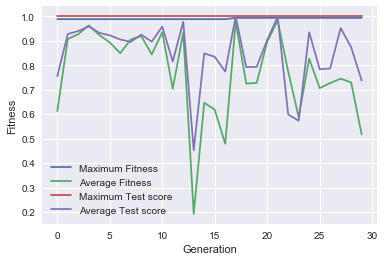

In [10]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
line1 = ax1.plot(gen, maxs, label='Maximum Fitness')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, avgs, label='Average Fitness')

line3 = ax1.plot(gen, maxs_tt, label='Maximum Test score')
line4 = ax1.plot(gen, avgs_tt, label='Average Test score')

lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")

plt.show()